## Stock Price Prediction using LSTM

- I will try to predict the stock prices using a simple LSTM model
- LSTM models are a good candidate for Time Series prediction as the future values are influenced by values of recent past.
- Author: [Shubham S Diwe](mailto:shubham_diwe@yahoo.com)
- Coursera - IBM Specialization: [Advanced Data Science Capstone](https://www.coursera.org/learn/ai/home/welcome)
- [Data Scource](https://data-flair.training/blogs/download-stocks-price-data/)

### Importing the necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

In [2]:
import h5py
import tensorflow as tf
from keras.preprocessing import sequence
from keras.models import Sequential, Model
from keras.layers import LSTM, Dropout, Dense, Input
# from keras.metrics import MeanAbsolutePercentageError, RootMeanSquaredError

Using TensorFlow backend.


In [3]:
batch_size = 64
epoch = 15
timesteps = 10

### Importing the dataset into the notebook

In [4]:
df_data_1 = pd.read_csv(body)
# df_data_1.head()

### Data Preprocessing and Exploration
- This is a very tailored dataset so the need for preprocessing is minimal. It is actually difficult to find a dataset which requires a lot of data cleaning.
- The dataset was checked for null values, irregularity in the date format, ordering of the date column, etc.
- None of these problems were encountered and hence the preprocessing steps have been commented.

In [5]:
(df_data_1.isna()).sum()

Date       0
Open       0
High       0
Low        0
Close      0
Volume     0
OpenInt    0
Stock      0
dtype: int64

**Feature Engineering**
- Convert the "Date" Column into the following format: "Year-Month-Date" for easier computation

In [6]:
df_data_1['Date'] = pd.to_datetime(df_data_1['Date'], format='%Y-%m-%d')

- Select only the Closing prices for each stock as we are interested in only this column

In [7]:
df = df_data_1.loc[:, ['Date', 'Close', 'Stock']]
df.head()

,Date,Close,Stock
0,1984-09-07,0.42388,AAPL
1,1984-09-10,0.42134,AAPL
2,1984-09-11,0.42902,AAPL
3,1984-09-12,0.41618,AAPL
4,1984-09-13,0.43927,AAPL


#### Visualizing the 4 time series

/opt/conda/envs/Python36/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


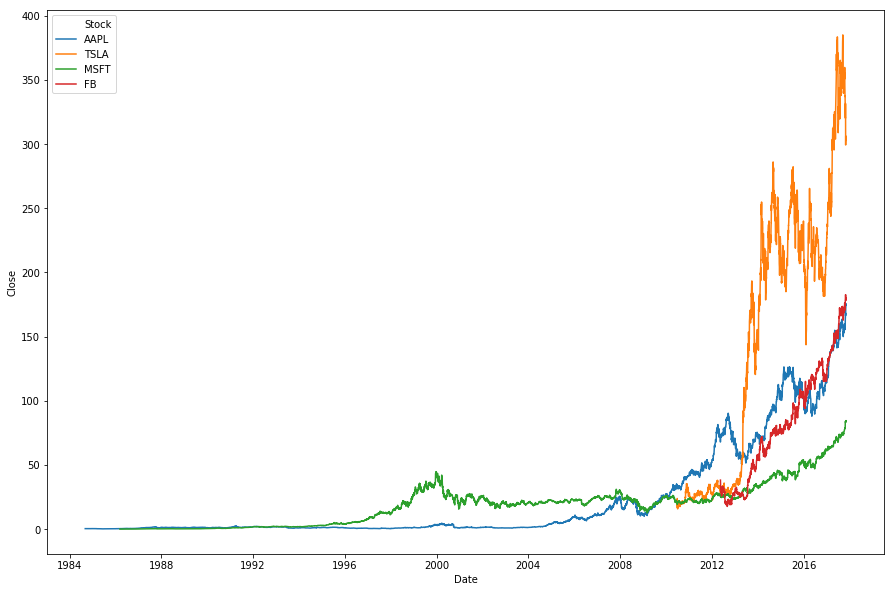

In [8]:
plt.figure(figsize=(15, 10))
sns.lineplot(x='Date', y='Close', hue='Stock', data=df)

#### Separating the time series based on stock name
- As is obvious, Apple and Microsoft have been in existence for considerably longer than Facebook and Tesla.
- So, the records for each company are for different amount of time.
- Hence, we separate the stocks and create a time series for each company.

In [9]:
d_aapl = df.loc[df['Stock'] == 'AAPL', ['Date', 'Close']]
d_fb = df.loc[df['Stock'] == 'FB', ['Date', 'Close']]
d_msft = df.loc[df['Stock'] == 'MSFT', ['Date', 'Close']]
d_tsla = df.loc[df['Stock'] == 'TSLA', ['Date', 'Close']]

In [10]:
d_msft.head()

,Date,Close
10222,1986-03-13,0.07533
10223,1986-03-14,0.07533
10224,1986-03-17,0.07533
10225,1986-03-18,0.07533
10226,1986-03-19,0.07533


In [11]:
d_aapl.shape, d_fb.shape, d_msft.shape, d_tsla.shape

((8364, 2), (1381, 2), (7983, 2), (1858, 2))

In [12]:
# Make date column as the index
def idx(data):
    d = data.copy()
#     d.index = d['Date']
    d.drop('Date', inplace=True, axis=1)
    return d

aapl = idx(d_aapl)
fb = idx(d_fb)
msft = idx(d_msft)
tsla = idx(d_tsla)

#### Scaling (Feature Engineering)
- For time series data, it is a recommended step to scale the data between 0 and 1 
- Scaling ensures better performance by not just neural networks, but other Machine learning Algorithms as well.
- It will also be beneficial for standardization, i.e., using the same model for time series of different stock.
- Scaling allows better optimization as the effect of very small or very large values also gets scaled between just 0 and 1 (in this case) or -1 and 1

In [13]:
# Scale the data
mms = MinMaxScaler(feature_range=(0, 1))
def scaler(d):
    d = mms.fit_transform(d)
    return d

def inv(d):
#     d = mms.fit_transform(d)
    iv = mms.inverse_transform(d)
    return iv

In [14]:
aapl = scaler(aapl)
fb = scaler(fb)
msft = scaler(msft)
tsla = scaler(tsla)

#### As the data for Apple stocks is the largest, let's use it for training and building the model

* Once the model is built, we can test if the model performs well on the other three time series.
* So, we will have a generic model that can predict the stock price for any stock.
* Also, as we can see the drastic change in stock prices for a few companies overtime, we will be able to see if the model generalizes well or not.

**Creating the training and testing data from the Apple time series**
- The week 3 lecture for LSTM forecasting from the [Applied AI with DeepLearning](https://www.coursera.org/learn/ai/lecture/jrzxM/number-of-time-steps-epochs-training-and-validation) is the reference for the following implementation.
- However, changes have been made as required for this case.

In [15]:
# Function to get the length of the training set and subsetting the data into training set as per requirement
def get_train_data(data, bs = batch_size, test=0.1, ts = timesteps):
    
    l = len(data)
    l *= 1 - test
    
    train_vals = []
    for i in range(int(l) - bs, int(l)):
        if (i % bs) == 0:
            train_vals.append(i)
            
    lmax = max(train_vals)
    
    return lmax

In [16]:
appl_len = get_train_data(aapl)
appl_len

7488

In [17]:
# Subsetting the complete data into training data as per length computed in the previous step
# training_data.shape # Not required in this case

In [18]:
# Creating training and testing sets
x_train = []
y_one = []
y_two = []

for i in range(timesteps, appl_len+timesteps):
    x_train.append(aapl[i-timesteps:i,0])
    y_one.append(aapl[i:i+timesteps, 0]) # Predict ten value in the future
    y_two.append(aapl[i, 0]) # Predict only one value in the future

In [19]:
len(x_train), len(y_one), (appl_len+timesteps), len(y_two)

(7488, 7488, 7498, 7488)

In [20]:
# Reshaping
def rs(dat):
    arr = np.array(dat)
    arr_rs = np.reshape(arr, (arr.shape[0], arr.shape[1], 1))
    return arr_rs

In [21]:
x_train = rs(x_train)
y_one = rs(y_one)
y_two = np.array(y_two) #rs(y_train)

x_train.shape, y_two.shape, y_one.shape

((7488, 10, 1), (7488,), (7488, 10, 1))

#### Building the LSTM Model

In [22]:
inputs_1_mape = Input(batch_shape=(batch_size, timesteps, 1))
lstm_1_mape = LSTM(units=20, stateful=True, return_sequences=True)(inputs_1_mape)
lstm_2_mape = LSTM(units=20, stateful=True, return_sequences=True)(lstm_1_mape)
lstm_3_mape = Dense(units=10)(lstm_2_mape)
output_mape = Dense(units=1)(lstm_3_mape)

lstm_model = Model(inputs=inputs_1_mape, outputs=output_mape)
lstm_model.compile(optimizer='adam', loss='mape')
lstm_model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (64, 10, 1)               0         
_________________________________________________________________
lstm_1 (LSTM)                (64, 10, 20)              1760      
_________________________________________________________________
lstm_2 (LSTM)                (64, 10, 20)              3280      
_________________________________________________________________
dense_1 (Dense)              (64, 10, 10)              210       
_________________________________________________________________
dense_2 (Dense)              (64, 10, 1)               11        
Total params: 5,261
Trainable params: 5,261
Non-trainable params: 0
_________________________________________________________________


In [23]:
for i in range(epoch):
    print('Epoch = ', str(i))
    lstm_model.fit(x_train, y_one, shuffle=False, epochs=1, verbose=1, batch_size=batch_size)
    lstm_model.reset_states()

Epoch =  0
Instructions for updating:
Use tf.cast instead.
Epoch 1/1
7488/7488 [==============================] - 16s 2ms/step - loss: 1145.9656
Epoch =  1
Epoch 1/1
7488/7488 [==============================] - 13s 2ms/step - loss: 3603.5748
Epoch =  2
Epoch 1/1
7488/7488 [==============================] - 14s 2ms/step - loss: 12914.5560
Epoch =  3
Epoch 1/1
7488/7488 [==============================] - 13s 2ms/step - loss: 6817.9267
Epoch =  4
Epoch 1/1
7488/7488 [==============================] - 15s 2ms/step - loss: 6765.9176
Epoch =  5
Epoch 1/1
7488/7488 [==============================] - 13s 2ms/step - loss: 5232.3143
Epoch =  6
Epoch 1/1
7488/7488 [==============================] - 15s 2ms/step - loss: 5594.9210
Epoch =  7
Epoch 1/1
7488/7488 [==============================] - 14s 2ms/step - loss: 5009.5053
Epoch =  8
Epoch 1/1
7488/7488 [==============================] - 13s 2ms/step - loss: 5051.4955
Epoch =  9
Epoch 1/1
7488/7488 [==============================] - 13s 2ms/step

In [24]:
aapl_test = aapl[7508:, 0]
len(aapl_test)

856

In [25]:
x_test = []
y_1 = []
y_2 = []

for i in range(2*timesteps, len(aapl_test)):
    x_test.append(aapl_test[i-2*timesteps:i-timesteps])
    y_1.append(aapl_test[i-timesteps:i])
    y_2.append(aapl_test[i])

x_test = rs(x_test)
y_1 = rs(y_1)

In [26]:
x_test = x_test[:832, :, :] # Subset to the nearest multiple of 64
y_1 = y_1[:832,] # Subset to the nearest multiple of 64
y_2 = y_2[:832]
# x_test.shape, y_test.shape
yt_1 = inv(np.reshape(y_1, (-1, 1))) # Convert test results back to original scale
yt_2 = inv(np.reshape(y_2, (-1, 1)))

In [27]:
p1 = lstm_model.predict(x_test, batch_size=batch_size) # Predict the values for test set

In [28]:
p1 = p1.reshape(2, -1)
p1.shape
# pk[0]

(2, 4160)

In [29]:
p0 = inv(p1) # Rescale the values from (0, 1) to (0, infinity) i.e., back to roiginal scale

In [30]:
# plt.figure(figsize=(15, 8))
# plt.plot(yt_1)
# plt.plot(p0)

In [31]:
lstm_model.evaluate(x_test, y_1, batch_size=64)

832/832 [==============================] - 1s 953us/step


102.35593590369591

In [32]:
lstm_model.save('lstm_model.h5')

**As we can see that the model is notperforming that good after training for 15 epochs and with the current model architecture**
- Let us add a few more neurons in the model
- Also, increase the number of training runs (epochs)

#### Building a new LSTM Model with more neurons

In [33]:
mod_lstm = Sequential()
mod_lstm.add(LSTM(25, return_sequences=True, input_shape=(x_train.shape[1], 1)))
mod_lstm.add(LSTM(25, return_sequences=False))
mod_lstm.add(Dense(20, activation='relu'))
mod_lstm.add(Dense(1))

mod_lstm.compile(optimizer='adam', loss='mae')

In [34]:
mod_lstm.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 10, 25)            2700      
_________________________________________________________________
lstm_4 (LSTM)                (None, 25)                5100      
_________________________________________________________________
dense_3 (Dense)              (None, 20)                520       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 21        
Total params: 8,341
Trainable params: 8,341
Non-trainable params: 0
_________________________________________________________________


**Training the model for 25 epochs, i.e., 25 runs of data**

In [35]:
mod_lstm.fit(x_train, y_two, epochs=25, verbose=1, batch_size=64)

Epoch 1/25
7488/7488 [==============================] - 18s 2ms/step - loss: 0.0178
Epoch 2/25
7488/7488 [==============================] - 14s 2ms/step - loss: 0.0030
Epoch 3/25
7488/7488 [==============================] - 14s 2ms/step - loss: 0.0028
Epoch 4/25
7488/7488 [==============================] - 14s 2ms/step - loss: 0.0029
Epoch 5/25
7488/7488 [==============================] - 14s 2ms/step - loss: 0.0028
Epoch 6/25
7488/7488 [==============================] - 14s 2ms/step - loss: 0.0029
Epoch 7/25
7488/7488 [==============================] - 14s 2ms/step - loss: 0.0027
Epoch 8/25
7488/7488 [==============================] - 14s 2ms/step - loss: 0.0028
Epoch 9/25
7488/7488 [==============================] - 14s 2ms/step - loss: 0.0026
Epoch 10/25
7488/7488 [==============================] - 14s 2ms/step - loss: 0.0025
Epoch 11/25
7488/7488 [==============================] - 14s 2ms/step - loss: 0.0024
Epoch 12/25
7488/7488 [==============================] - 14s 2ms/step - lo

In [36]:
p2 = mod_lstm.predict(x_test) # Predicting the values

In [37]:
mod_lstm.evaluate(x_test, y_2) # Evaluating the model peformance

832/832 [==============================] - 1s 1ms/step


0.02673763917902341

In [38]:
mod_lstm.metrics_names

['loss']

In [39]:
pt = inv(p2)

**Let us compute the mean absolute error of the predictions once we scale them back to original values**

In [40]:
abs(yt_2 - pt).mean() 

9.871535653427431

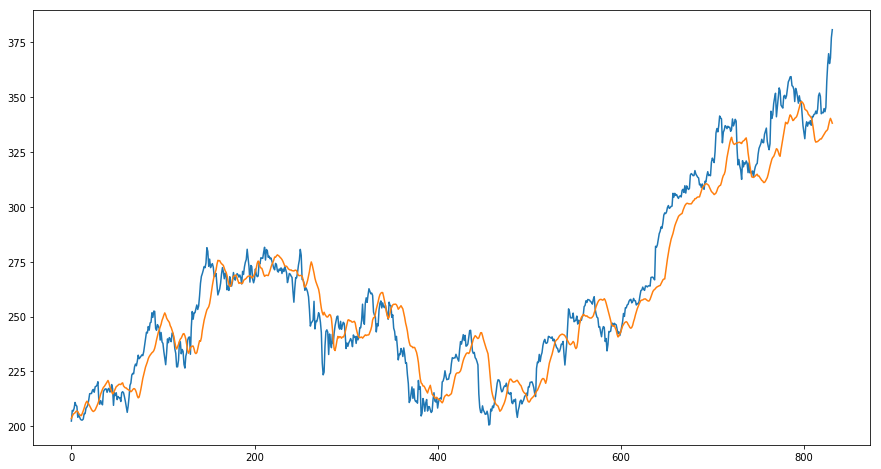

In [41]:
plt.figure(figsize=(15, 8))
plt.plot(yt_2)
plt.plot(pt)

**As we can see from the above plot, the model is doing a great job at prediction**
- The predictions almost mimic the original data except for the sharp edges,
- The Mean Absolute Error of just 8.385 in 832 predictions is an indicator of a good model
- The model is successful in predicting the direction of the stock price for certain.

In [42]:
mod_lstm.save('lstm_wts.h5') # Saving the models
# stored_model = client.repository.store_model(mod_lstm, 'LSTM_SPP')

#### Choice of error metrics:
- For time series data, the typical error measurement metrics are: Root Mean Squared Error (RMSE), Mean Squared Error (MSE), Mean Absolute Error (MAE), Mean Absolute percentage Error (MAPE) and Symmetric Mean Absolute Percentage Error (sMAPE)
- The **MSE** and **RMSE** are not usually considered good for time series data as they do not directly convey the degree of variance between prediction and actual values.
- In this regard, MAPE and MAE perform a bit better as with the values of MAPE/MAE, we get a better idea of the degree of variance.
- **MAPE** and **MAE** are one and the same thing. MAPE is just the percentage form of MAE.
- **sMAPE** is a very useful metric for time series error measurement but is best suited for sparse time series data. Example: Sales of a commodity from a physical store.
- Keeping these in mind, the error metric selected for this task was **MAPE** and **MAE**.

#### Testing the model performance on time series of other stocks

In [43]:
# A function combining all preprocessing steps to create the input and labels for the model
def get_test_sets(d, bs = batch_size, ts = timesteps):
    
    l = len(d)
    
    train_vals = []
    for i in range(int(l) - bs, int(l)):
        if (i % bs) == 0:
            train_vals.append(i)
            
    lmax = max(train_vals)
    
    if lmax >= (l - 2*ts):
        upper = lmax - 2*ts
    else:
        upper = lmax + 2*ts
    
    td = d[0:upper,]
    op_x = []
    op_y = []
    for i in range(ts, lmax+ts):
        op_x.append(td[(i-ts):i,0])
        op_y.append(td[i, 0])
        
    op_x = rs(op_x)
    op_y = np.array(op_y)
    
    return (op_x, op_y)

In [44]:
fb_x, fb_y = get_test_sets(fb)
msft_x, msft_y = get_test_sets(msft)

In [45]:
mod_lstm.evaluate(fb_x, fb_y, batch_size=batch_size)

1344/1344 [==============================] - 0s 129us/step


0.010978262294970807

In [46]:
pred_fb = mod_lstm.predict(fb_x)

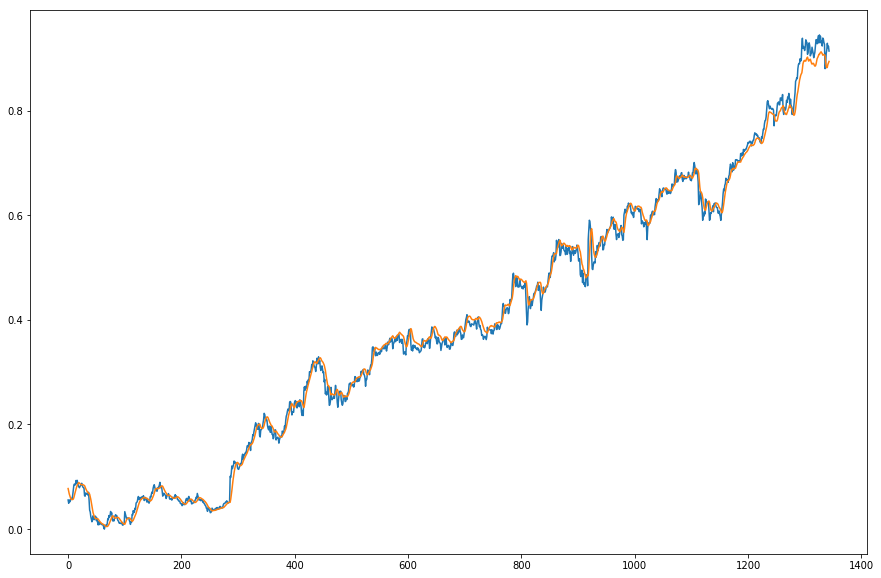

In [47]:
plt.figure(figsize=(15, 10))
plt.plot(fb_y)
plt.plot(pred_fb)

In [48]:
mod_lstm.evaluate(msft_x, msft_y, batch_size=batch_size)

7936/7936 [==============================] - 1s 132us/step


0.005906850445288939

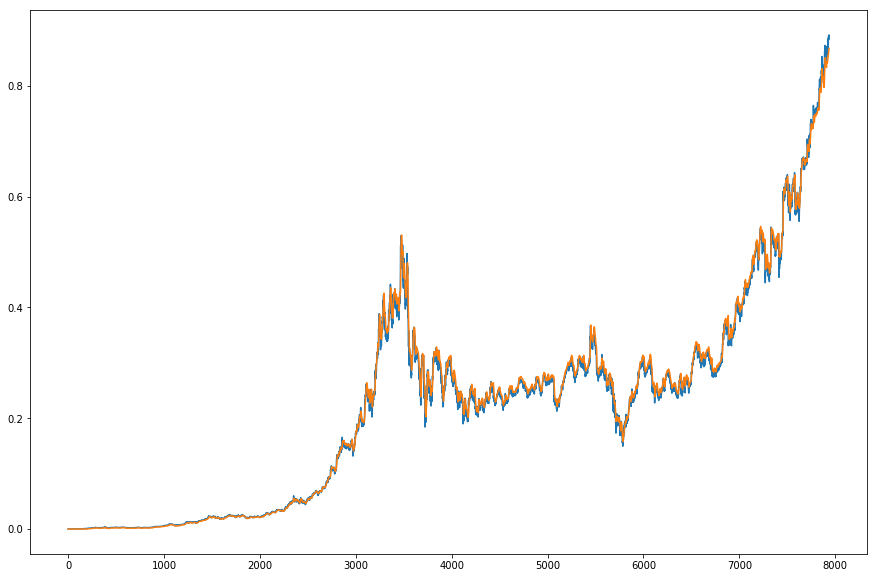

In [49]:
pred_msft = mod_lstm.predict(msft_x)
plt.figure(figsize=(15, 10))
plt.plot(msft_y)
plt.plot(pred_msft)

In [50]:
# p_msft = inv(pred_msft)
# p_fb = inv(pred_fb)

In [51]:
# p_msft = p_msft.tolist()
# p_fb = p_fb.tolist()

In [52]:
# msft_p = d_msft.iloc[0:len(p_msft), :]
# fb_p = d_fb.iloc[0:len(p_fb), :]

In [53]:
# msft_p['Pred'] = p_msft
# fb_p['Pred'] = p_fb